In [91]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import kerastuner as kt
from sklearn.model_selection import train_test_split

In [334]:
#input with all maxima
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
x_data_string=df_spectra_all["all_maxima"].values

max_nr_of_max=df_spectra_all['no_of_max'].max()
len_array=len(df_spectra_all["all_maxima"].values)

print(max_nr_of_max,len_array)
x_data_padded=np.zeros((len_array,max_nr_of_max))

for i,x_string in enumerate(x_data_string):
    x_string=x_string.replace('\n','').replace('[','').replace(']','')
    x_split= x_string.split(' ')
    j=0
    for x in (x_split):
        if(x!=''):
            #print(x)
            x_data_padded[i,j]=float(x)
            j=j+1
    #print("cut")

y_data=df_spectra[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()


y_data=y_data-0.5
y_data=y_data*4


data_train, data_test, labels_train, labels_test = train_test_split(x_data_padded, y_data, test_size=0.20, random_state=42)
   
print(data_train.shape)

22 729
(583, 22)


def transform_data(df,index):
    data=df[index].to_numpy()
    new_data=np.zeros((len(data),max(data)+1))    
    for i in range(len(data)):
        new_data[i,data[i]]=1
    return new_data
    
df_spectra=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
df_new=df_spectra.loc[df_spectra["k11"] == 0]


x_data=transform_data(df_new,"no_of_max")
print(x_data[0:2])



y_data=df_spectra[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()


y_data=y_data-0.5
y_data=y_data*4
print(y_data[0:10])


data_train, data_test, labels_train, labels_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)

print(data_train.shape)
print(labels_train.shape)

#df_training = df_spectra.sample(frac=0.8,random_state=10)
#df_testing=df_spectra.drop(df_training.index)
#df_spectra.head()

In [335]:
feature_columns_A = []

no_of_max = tf.feature_column.numeric_column("all_maxima")
my_feature_layer_A = tf.keras.layers.DenseFeatures(no_of_max_bucket)

#transform data


In [354]:

def plot_the_loss_curve(epochs, mse,val_mse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.plot(epochs, val_mse, label="Val Loss")

    plt.legend()
    #plt.ylim([0, 15])
    plt.show()  

def create_model(my_learning_rate, my_feature_layer):
    model = tf.keras.models.Sequential()
    # Add the layer containing the feature columns to the model.
    # Define the first hidden layer with 10 nodes.   
   # model.add(my_feature_layer_A)
    #layers=[5,10]
    layers=[2000,3500,300,2000,3000,30,200,300,30]
    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = 'sigmoid',kernel_regularizer=tf.keras.regularizers.l1(0.0)))
    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=6,  
                                    name='Output',activation="sigmoid"))#,kernel_regularizer=tf.keras.regularizers.l2(0.04)))                              
  
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=my_learning_rate,momentum=0.1),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model



def train_model(model, x,y, epochs, label_name,
                batch_size=None):

    #features = {name:np.array(value) for name, value in dataset.items()}
    #label=dataset[label_name].to_numpy()
    history = model.fit(x=x, y=y, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=1,validation_split=0.2) 
    
    epochs = history.epoch
  
    df_hist = pd.DataFrame(history.history)
    #hist.head()
    #mse = hist["mean_squared_error"]
    mae = df_hist["mean_squared_error"].to_numpy()
    val_mae = df_hist["val_mean_squared_error"].to_numpy()
    return epochs,mae,val_mae

In [355]:
# The following variables are the hyperparameters.
#data_train, data_test, labels_train, labels_test
learning_rate = 1e-1
epochs = 500
batch_size = 400

label_name = ["k6a1","k6a2","k11","k12","k9a1","k9a2"]

my_model = create_model(learning_rate, my_feature_layer_A)

epochs, mse,val_mse = train_model(my_model, data_train,labels_train, epochs, 
                          label_name, batch_size)


Epoch 1/500

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

2/2 [==============================] - ETA: 0s - loss: 0.9329 - mean_squared_error: 0.93 - 0s 70ms/step - loss: 0.9385 - mean_squared_error: 0.9385 - val_loss: 0.9229 - val_mean_squared_error: 0.9229
Epoch 2/500
2/2 [==============================] - ETA: 0s - loss: 0.9101 - mean_squared_error: 0.91 - 0s 39ms/step - loss: 0.9073 - mean_squared_error: 0.9073 - val_loss: 0.8939 - val_mean_squared_error: 0.8939
Epoch 3/500
2/2 [==============================] - ETA: 0s - loss: 0.8814 - mean_squ

Epoch 31/500
2/2 [==============================] - ETA: 0s - loss: 0.6830 - mean_squared_error: 0.68 - ETA: 0s - loss: 0.6865 - mean_squared_error: 0.68 - 0s 42ms/step - loss: 0.6865 - mean_squared_error: 0.6865 - val_loss: 0.7093 - val_mean_squared_error: 0.7093
Epoch 32/500
2/2 [==============================] - ETA: 0s - loss: 0.6878 - mean_squared_error: 0.68 - ETA: 0s - loss: 0.6857 - mean_squared_error: 0.68 - 0s 41ms/step - loss: 0.6857 - mean_squared_error: 0.6857 - val_loss: 0.7086 - val_mean_squared_error: 0.7086
Epoch 33/500
2/2 [==============================] - ETA: 0s - loss: 0.6875 - mean_squared_error: 0.68 - ETA: 0s - loss: 0.6849 - mean_squared_error: 0.68 - 0s 42ms/step - loss: 0.6849 - mean_squared_error: 0.6849 - val_loss: 0.7080 - val_mean_squared_error: 0.7080
Epoch 34/500
2/2 [==============================] - ETA: 0s - loss: 0.6841 - mean_squared_error: 0.68 - ETA: 0s - loss: 0.6843 - mean_squared_error: 0.68 - 0s 41ms/step - loss: 0.6843 - mean_squared_error:

2/2 [==============================] - ETA: 0s - loss: 0.6815 - mean_squared_error: 0.68 - ETA: 0s - loss: 0.6739 - mean_squared_error: 0.67 - 0s 42ms/step - loss: 0.6739 - mean_squared_error: 0.6739 - val_loss: 0.6977 - val_mean_squared_error: 0.6977
Epoch 64/500
2/2 [==============================] - ETA: 0s - loss: 0.6661 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6737 - mean_squared_error: 0.67 - 0s 44ms/step - loss: 0.6737 - mean_squared_error: 0.6737 - val_loss: 0.6975 - val_mean_squared_error: 0.6975
Epoch 65/500
2/2 [==============================] - ETA: 0s - loss: 0.6765 - mean_squared_error: 0.67 - 0s 39ms/step - loss: 0.6735 - mean_squared_error: 0.6735 - val_loss: 0.6973 - val_mean_squared_error: 0.6973
Epoch 66/500
2/2 [==============================] - ETA: 0s - loss: 0.6700 - mean_squared_error: 0.67 - ETA: 0s - loss: 0.6734 - mean_squared_error: 0.67 - 0s 42ms/step - loss: 0.6734 - mean_squared_error: 0.6734 - val_loss: 0.6971 - val_mean_squared_error: 0.6971
Epoch

2/2 [==============================] - ETA: 0s - loss: 0.6694 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6704 - mean_squared_error: 0.67 - 0s 43ms/step - loss: 0.6704 - mean_squared_error: 0.6704 - val_loss: 0.6941 - val_mean_squared_error: 0.6941
Epoch 96/500
2/2 [==============================] - ETA: 0s - loss: 0.6781 - mean_squared_error: 0.67 - ETA: 0s - loss: 0.6703 - mean_squared_error: 0.67 - 0s 42ms/step - loss: 0.6703 - mean_squared_error: 0.6703 - val_loss: 0.6941 - val_mean_squared_error: 0.6941
Epoch 97/500
2/2 [==============================] - ETA: 0s - loss: 0.6636 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6703 - mean_squared_error: 0.6703 - val_loss: 0.6940 - val_mean_squared_error: 0.6940
Epoch 98/500
2/2 [==============================] - ETA: 0s - loss: 0.6683 - mean_squared_error: 0.66 - 0s 38ms/step - loss: 0.6702 - mean_squared_error: 0.6702 - val_loss: 0.6939 - val_mean_squared_error: 0.6939
Epoch 99/500
2/2 [==============================] - ETA: 

Epoch 129/500
2/2 [==============================] - ETA: 0s - loss: 0.6687 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6687 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6687 - mean_squared_error: 0.6687 - val_loss: 0.6924 - val_mean_squared_error: 0.6924
Epoch 130/500
2/2 [==============================] - ETA: 0s - loss: 0.6711 - mean_squared_error: 0.67 - 0s 38ms/step - loss: 0.6687 - mean_squared_error: 0.6687 - val_loss: 0.6924 - val_mean_squared_error: 0.6924
Epoch 131/500
2/2 [==============================] - ETA: 0s - loss: 0.6694 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6686 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6686 - mean_squared_error: 0.6686 - val_loss: 0.6924 - val_mean_squared_error: 0.6924
Epoch 132/500
2/2 [==============================] - ETA: 0s - loss: 0.6703 - mean_squared_error: 0.67 - ETA: 0s - loss: 0.6686 - mean_squared_error: 0.66 - 0s 43ms/step - loss: 0.6686 - mean_squared_error: 0.6686 - val_loss: 0.6923 - val_mean_squared_er

2/2 [==============================] - ETA: 0s - loss: 0.6704 - mean_squared_error: 0.67 - 0s 38ms/step - loss: 0.6678 - mean_squared_error: 0.6678 - val_loss: 0.6917 - val_mean_squared_error: 0.6917
Epoch 163/500
2/2 [==============================] - ETA: 0s - loss: 0.6712 - mean_squared_error: 0.67 - 0s 39ms/step - loss: 0.6678 - mean_squared_error: 0.6678 - val_loss: 0.6917 - val_mean_squared_error: 0.6917
Epoch 164/500
2/2 [==============================] - ETA: 0s - loss: 0.6682 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6677 - mean_squared_error: 0.6677 - val_loss: 0.6916 - val_mean_squared_error: 0.6916
Epoch 165/500
2/2 [==============================] - ETA: 0s - loss: 0.6695 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6677 - mean_squared_error: 0.66 - 0s 41ms/step - loss: 0.6677 - mean_squared_error: 0.6677 - val_loss: 0.6916 - val_mean_squared_error: 0.6916
Epoch 166/500
2/2 [==============================] - ETA: 0s - loss: 0.6621 - mean_squared_error: 0.66 - 0

2/2 [==============================] - ETA: 0s - loss: 0.6609 - mean_squared_error: 0.66 - 0s 40ms/step - loss: 0.6673 - mean_squared_error: 0.6673 - val_loss: 0.6912 - val_mean_squared_error: 0.6912
Epoch 196/500
2/2 [==============================] - ETA: 0s - loss: 0.6597 - mean_squared_error: 0.65 - ETA: 0s - loss: 0.6672 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6672 - mean_squared_error: 0.6672 - val_loss: 0.6911 - val_mean_squared_error: 0.6911
Epoch 197/500
2/2 [==============================] - ETA: 0s - loss: 0.6667 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6672 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6672 - mean_squared_error: 0.6672 - val_loss: 0.6911 - val_mean_squared_error: 0.6911
Epoch 198/500
2/2 [==============================] - ETA: 0s - loss: 0.6589 - mean_squared_error: 0.65 - ETA: 0s - loss: 0.6672 - mean_squared_error: 0.66 - 0s 44ms/step - loss: 0.6672 - mean_squared_error: 0.6672 - val_loss: 0.6910 - val_mean_squared_error: 0.6910
Ep

2/2 [==============================] - ETA: 0s - loss: 0.6661 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6669 - mean_squared_error: 0.66 - 0s 44ms/step - loss: 0.6669 - mean_squared_error: 0.6669 - val_loss: 0.6907 - val_mean_squared_error: 0.6907
Epoch 227/500
2/2 [==============================] - ETA: 0s - loss: 0.6703 - mean_squared_error: 0.67 - ETA: 0s - loss: 0.6669 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6669 - mean_squared_error: 0.6669 - val_loss: 0.6906 - val_mean_squared_error: 0.6906
Epoch 228/500
2/2 [==============================] - ETA: 0s - loss: 0.6682 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6669 - mean_squared_error: 0.66 - 0s 43ms/step - loss: 0.6669 - mean_squared_error: 0.6669 - val_loss: 0.6906 - val_mean_squared_error: 0.6906
Epoch 229/500
2/2 [==============================] - ETA: 0s - loss: 0.6679 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6669 - mean_squared_error: 0.66 - 0s 44ms/step - loss: 0.6669 - mean_squared_error: 0.6669 - 

2/2 [==============================] - ETA: 0s - loss: 0.6692 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6666 - mean_squared_error: 0.66 - 0s 44ms/step - loss: 0.6666 - mean_squared_error: 0.6666 - val_loss: 0.6903 - val_mean_squared_error: 0.6903
Epoch 258/500
2/2 [==============================] - ETA: 0s - loss: 0.6649 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6666 - mean_squared_error: 0.66 - 0s 44ms/step - loss: 0.6666 - mean_squared_error: 0.6666 - val_loss: 0.6903 - val_mean_squared_error: 0.6903
Epoch 259/500
2/2 [==============================] - ETA: 0s - loss: 0.6674 - mean_squared_error: 0.66 - 0s 40ms/step - loss: 0.6666 - mean_squared_error: 0.6666 - val_loss: 0.6903 - val_mean_squared_error: 0.6903
Epoch 260/500
2/2 [==============================] - ETA: 0s - loss: 0.6675 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6666 - mean_squared_error: 0.66 - 0s 47ms/step - loss: 0.6666 - mean_squared_error: 0.6666 - val_loss: 0.6903 - val_mean_squared_error: 0.6903
Ep

2/2 [==============================] - ETA: 0s - loss: 0.6682 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6664 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6901 - val_mean_squared_error: 0.6901
Epoch 290/500
2/2 [==============================] - ETA: 0s - loss: 0.6711 - mean_squared_error: 0.67 - 0s 39ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6901 - val_mean_squared_error: 0.6901
Epoch 291/500
2/2 [==============================] - ETA: 0s - loss: 0.6655 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6664 - mean_squared_error: 0.66 - 0s 43ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6901 - val_mean_squared_error: 0.6901
Epoch 292/500
2/2 [==============================] - ETA: 0s - loss: 0.6603 - mean_squared_error: 0.66 - 0s 40ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 0.6901 - val_mean_squared_error: 0.6901
Epoch 293/500
2/2 [==============================] - E

Epoch 323/500
2/2 [==============================] - ETA: 0s - loss: 0.6685 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6663 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6663 - mean_squared_error: 0.6663 - val_loss: 0.6900 - val_mean_squared_error: 0.6900
Epoch 324/500
2/2 [==============================] - ETA: 0s - loss: 0.6616 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6663 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6663 - mean_squared_error: 0.6663 - val_loss: 0.6900 - val_mean_squared_error: 0.6900
Epoch 325/500
2/2 [==============================] - ETA: 0s - loss: 0.6702 - mean_squared_error: 0.67 - ETA: 0s - loss: 0.6662 - mean_squared_error: 0.66 - 0s 44ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - val_loss: 0.6900 - val_mean_squared_error: 0.6900
Epoch 326/500
2/2 [==============================] - ETA: 0s - loss: 0.6638 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6662 - mean_squared_error: 0.66 - 0s 43ms/step - loss: 0.6662 - mean_squared_er

2/2 [==============================] - ETA: 0s - loss: 0.6614 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6661 - mean_squared_error: 0.66 - 0s 44ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Epoch 355/500
2/2 [==============================] - ETA: 0s - loss: 0.6712 - mean_squared_error: 0.67 - ETA: 0s - loss: 0.6661 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Epoch 356/500
2/2 [==============================] - ETA: 0s - loss: 0.6645 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6661 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Epoch 357/500
2/2 [==============================] - ETA: 0s - loss: 0.6688 - mean_squared_error: 0.66 - 0s 40ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Ep

2/2 [==============================] - ETA: 0s - loss: 0.6635 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6660 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Epoch 387/500
2/2 [==============================] - ETA: 0s - loss: 0.6650 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Epoch 388/500
2/2 [==============================] - ETA: 0s - loss: 0.6613 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6660 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Epoch 389/500
2/2 [==============================] - ETA: 0s - loss: 0.6728 - mean_squared_error: 0.67 - ETA: 0s - loss: 0.6660 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6660 - mean_squared_error: 0.6660 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Ep

Epoch 419/500
2/2 [==============================] - ETA: 0s - loss: 0.6629 - mean_squared_error: 0.66 - 0s 40ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Epoch 420/500
2/2 [==============================] - ETA: 0s - loss: 0.6657 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6659 - mean_squared_error: 0.66 - 0s 43ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Epoch 421/500
2/2 [==============================] - ETA: 0s - loss: 0.6679 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6659 - mean_squared_error: 0.66 - 0s 43ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6899 - val_mean_squared_error: 0.6899
Epoch 422/500
2/2 [==============================] - ETA: 0s - loss: 0.6575 - mean_squared_error: 0.65 - ETA: 0s - loss: 0.6659 - mean_squared_error: 0.66 - 0s 43ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6899 - val_mean_squared_er

2/2 [==============================] - ETA: 0s - loss: 0.6622 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6659 - mean_squared_error: 0.66 - 0s 41ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6897 - val_mean_squared_error: 0.6897
Epoch 454/500
2/2 [==============================] - ETA: 0s - loss: 0.6630 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6897 - val_mean_squared_error: 0.6897
Epoch 455/500
2/2 [==============================] - ETA: 0s - loss: 0.6692 - mean_squared_error: 0.66 - 0s 39ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6897 - val_mean_squared_error: 0.6897
Epoch 456/500
2/2 [==============================] - ETA: 0s - loss: 0.6654 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6659 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6659 - mean_squared_error: 0.6659 - val_loss: 0.6897 - val_mean_squared_error: 0.6897
Epoch 457/500
2/2 [==============================] - E

2/2 [==============================] - ETA: 0s - loss: 0.6694 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6658 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6897 - val_mean_squared_error: 0.6897
Epoch 488/500
2/2 [==============================] - ETA: 0s - loss: 0.6643 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6658 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6896 - val_mean_squared_error: 0.6896
Epoch 489/500
2/2 [==============================] - ETA: 0s - loss: 0.6663 - mean_squared_error: 0.66 - ETA: 0s - loss: 0.6658 - mean_squared_error: 0.66 - 0s 43ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - val_loss: 0.6897 - val_mean_squared_error: 0.6897
Epoch 490/500
2/2 [==============================] - ETA: 0s - loss: 0.6702 - mean_squared_error: 0.67 - ETA: 0s - loss: 0.6658 - mean_squared_error: 0.66 - 0s 42ms/step - loss: 0.6658 - mean_squared_error: 0.6658 - 

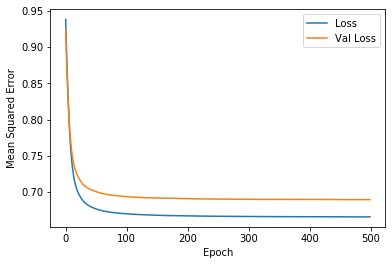

1/1 [==============================] - ETA: 0s - loss: 0.6584 - mean_squared_error: 0.65 - 0s 1ms/step - loss: 0.6584 - mean_squared_error: 0.6584
[0.6584183573722839, 0.6584183573722839]


,k6a1_test,k6a2_test,k11_test,k12_test,k9a1_test,k9a2_test,k6a1_hat,k6a2_hat,k11_hat,k12_hat,k9a1_hat,k9a2_hat
0,0.0,1.0,1.0,0.0,-1.0,-1.0,0.062683,0.02823,0.029467,0.025553,0.027512,0.042869
1,-1.0,0.0,1.0,0.0,0.0,0.0,0.062683,0.02823,0.029467,0.025553,0.027512,0.042869
2,0.0,-1.0,1.0,-1.0,0.0,1.0,0.062683,0.02823,0.029467,0.025553,0.027512,0.042869
3,0.0,0.0,0.0,-1.0,0.0,0.0,0.062683,0.02823,0.029467,0.025553,0.027512,0.042869
4,1.0,-1.0,0.0,-1.0,-1.0,1.0,0.062683,0.02823,0.029467,0.025553,0.027512,0.042869


In [356]:
features = {name:np.array(value) for name, value in df_testing.items()}
label=df_testing[label_name].to_numpy()
#data_train, data_test, labels_train, labels_test
plot_the_loss_curve(epochs, mse,val_mse)
evaluation=my_model.evaluate(x = data_test, y = labels_test, batch_size=batch_size)
predicted = my_model.predict(data_test)
print(evaluation)



df_test=pd.DataFrame(labels_test,columns=["k6a1_test","k6a2_test","k11_test","k12_test","k9a1_test","k9a2_test"])
df_predict=pd.DataFrame(predicted,columns=["k6a1_hat","k6a2_hat","k11_hat","k12_hat","k9a1_hat","k9a2_hat"])
pd.concat([df_test,df_predict], axis=1).head()

In [357]:
print(data_test[0:5])
print(labels_test[0:5])


[[-0.124  0.184  0.466  0.808  0.858  0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.462  0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [-0.932 -0.774 -0.706 -0.628 -0.488 -0.424 -0.34  -0.17  -0.086 -0.032
   0.12   0.142  0.204  0.274  0.456  0.508  0.586  0.73   0.812  0.864
   0.91   0.   ]
 [-0.42   0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [-0.932 -0.772 -0.704 -0.628 -0.488 -0.424 -0.34  -0.178 -0.136 -0.084
  -0.034  0.116  0.202  0.274  0.456  0.506  0.592  0.73   0.81   0.864
   0.912  0.   ]]
[[ 0.  1.  1.  0. -1. -1.]
 [-1.  0.  1.  0.  0.  0.]
 [ 0. -1.  1. -1.  0.  1.]
 [ 0.  0.  0. -1.  0.  0.]
 [ 1. -1.  0. -1. -1.  1.]]
